In [28]:
import os
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

import plotly.express as px
import plotly.graph_objects as go
import plotly.offline as pyo
import plotly.io as pio
from plotly.subplots import make_subplots

pyo.init_notebook_mode(connected = True)

from sklearn.metrics import roc_auc_score
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import (
    GridSearchCV,
    train_test_split,
    cross_val_score,
    GroupShuffleSplit,
    permutation_test_score,
    StratifiedKFold,
    KFold
)

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

from sklearn.ensemble import ExtraTreesClassifier

from utils import multivariate_classifier

In [29]:
# plotting parameters
grey = "#21201F"
green = "#9AC529"
lblue = "#42B9B2"
pink = "#DE237B"
orange = "#F38A31"

nt_colors = [green, lblue, pink, orange]

plt.style.use("ggplot")
fig_width = 12  # width in inches
fig_height = 9  # height in inches
fig_size = [fig_width, fig_height]
plt.rcParams["figure.figsize"] = fig_size
plt.rcParams["figure.autolayout"] = True

sns.set(
    style="white",
    context="notebook",
    font_scale=1,
    rc={
        "axes.labelcolor": grey,
        "text.color": grey,
        "axes.edgecolor": grey,
        "xtick.color": grey,
        "ytick.color": grey,
    },
)

sns.set_palette(sns.color_palette
(nt_colors))

# Load Data

In [36]:
markers = ['wSMI_1', 'wSMI_2', 'wSMI_4', 'wSMI_8', 'p_e_1', 'p_e_2',
       'p_e_4', 'p_e_8', 'k', 'se','msf', 'sef90', 'sef95', 'b', 'b_n', 'g',
       'g_n', 't', 't_n', 'd', 'd_n', 'a_n', 'a', 
#            'CNV', 'P1', 'P3a', 'P3b'
          ]
erps =['CNV', 'P1', 'P3a', 'P3b']

# Load Mindwandering DATA

In [46]:
epoch_type = "evoked"
# epoch_type = 'pseudo-rs'

all_participants = [
    "VP07",
    "VP08",
    "VP09",
    "VP10",
    "VP11",
    "VP12",
    "VP13",
    "VP14",
    "VP18",
    "VP19",
    "VP20",
    "VP22",
    "VP23",
    "VP24",
    "VP25",
    "VP26",
    "VP27",
    "VP28",
    "VP29",
    "VP30",
    "VP31",
    "VP32",
    "VP33",
    "VP35",
    "VP36",
    "VP37",
]

path = "/media/nicolas.bruno/63f8a366-34b7-4896-a7ce-b5fb4ee78535/Nico/MW_eeg_data/minmarker/"  # icm-linux
# path = '/Users/nicobruno/ownCloud/MW_eeg_data/minmarker/' #nico-mac

df = pd.DataFrame()

for i, v in enumerate(all_participants):
    participant = v

    folder = path + participant + "/"

    df_ = pd.read_csv(
        folder + participant + "_" + epoch_type + "_all_marker.csv", index_col=0
    )
    df_["participant"] = i
    df = df.append(df_)




# markers =  [r'$\delta$',r'$|\delta|$',r'$\theta$', r'$|\theta|$',r'$\alpha$', r'$|\alpha|$',r'$\beta$', r'$|\beta|$',r'$\gamma$', r'$|\gamma|$',
#             r'$PE\gamma$',r'$PE\beta$',r'$PE\alpha$',r'$PE\theta$',
#             r'$wSMI\gamma$',r'$wSMI\beta$',r'$wSMI\alpha$',r'$wSMI\theta$', 
#             r'$K$',r'$SE$',r'$MSF$', r'$SEF90$', r'$SEF95$', 
#             r'$CNV$', r'$P1$', r'$P3a$',r'$P3b$'
#            ]


# df_subtracted = df.query("preproc == 'subtracted'").drop(columns = erps+['preproc'])
# df_erp = df.query("preproc == 'erp'").drop(columns = np.setdiff1d(markers,erps).tolist()+['preproc'])

# df_markers = df_subtracted.merge(df_erp, 'inner', on =np.setdiff1d(df_subtracted.columns, markers).tolist() )

df_markers = (df
              .query("stimuli == 'go'")
              .query("correct == 'correct'")
            .query('prev_trial < 5')
              .drop(['stimuli', 'correct', 'prev_trial', 'label', 'events',  'epoch_type', 'preproc'], axis = 1)
              .drop(erps, axis=1)
              .query("mind in ['on-task','dMW', 'sMW']")
              .groupby(['segment', 'participant']).filter(lambda x: len(x) > 1)
             )

# df_markers.to_csv('Data/all_markers.csv')


agg_dict = {k: ["mean", 'std'] for k in markers}
agg_dict.update({k: "first" for k in df_markers.drop(markers, axis=1).columns})

df_mind = (
    df_markers.query("probe == 'PC'")
    .groupby(["segment", "participant"], as_index=False)
    .agg(agg_dict)
    #     .query("mind != 'sMW'") #if you want to test against just one of the mw
    .assign(mind2=lambda df: np.where(df.mind == "on-task", "on-task", "mw"))
)

df_mind.columns = df_mind.columns.map("_".join)

df_mind = df_mind.rename(
    columns={
        "participant_first": "participant",
        "probe_first": "probe",
        "mind_first": "mind",
        "segment_first": "segment",
        "mind2_": "mind2",
    }
).drop(["participant", "probe", "mind2", "segment"], axis=1)

# Load DOC patients DATA

In [61]:
path = "/media/nicolas.bruno/63f8a366-34b7-4896-a7ce-b5fb4ee78535/Nico/DOC patients/DOC_markers/"

classes = os.listdir(path)
classes

['HC', 'EMCS', 'MCS', 'VS']

In [62]:
df = pd.DataFrame()

for i in classes:
    
    files = os.listdir(path + i + '/')
    cat = i

    for file in files:
        
        participant = file[:7]
        
        df_ = pd.read_csv(path + i + '/' + file, index_col=0)
        df_["participant"] = participant
        df_['category'] = cat
        
        df = df.append(df_)
        
        
        

## VS vs MCS

In [64]:
classification = ['VS', 'MCS']

df = df.drop(erps, axis = 1)

agg_dict = {k: ["mean", 'std'] for k in markers}
agg_dict.update({k: "first" for k in df.drop(markers, axis=1).columns})

df_doc = (
    df.query(f"category in {classification}")
    .groupby(["participant", 'category'], as_index=False)
    .agg(agg_dict)
)

df_doc.columns = df_doc.columns.map("_".join)

df_doc = df_doc.rename(
    columns={
        "participant_first": "participant",
        "category_first": "category",
    }
).drop(["participant"], axis=1)


In [41]:
data = df_doc
label = 'category'
features = df_doc.drop('category', axis = 1).columns

cv_splits= 5
n_permutations = 1000
n_estimators = 1000
max_depth = None
max_features='auto'

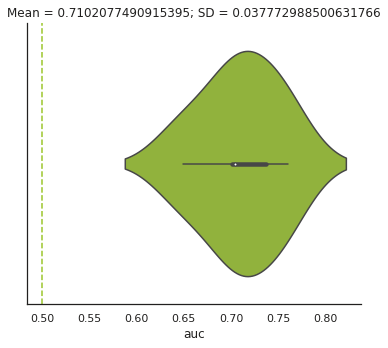

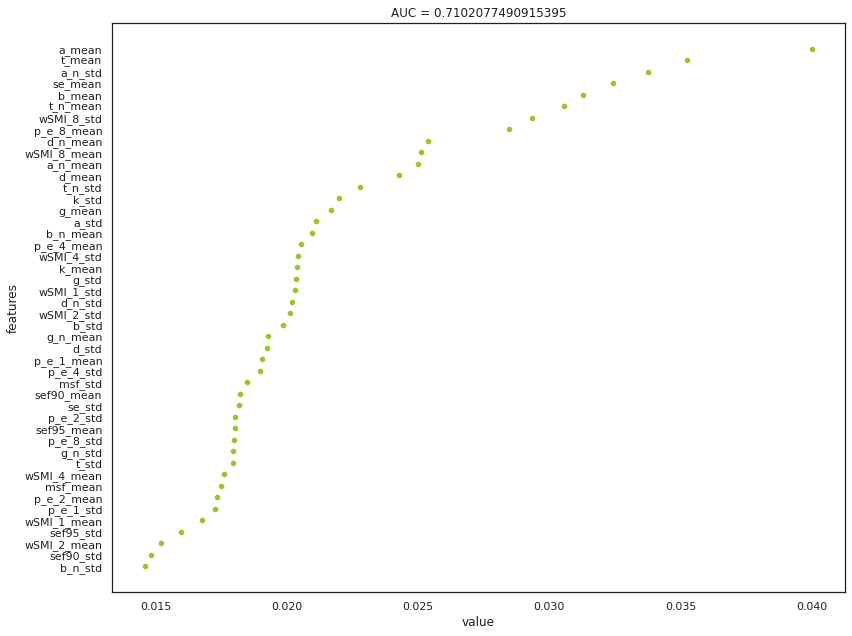

In [42]:
#pipeline steps init
steps = [("scaler", StandardScaler())]


y, lbl = pd.factorize(data[label])
X = data[features].astype("float32").values

steps.append(('Forest',ExtraTreesClassifier(
        n_estimators=n_estimators, max_features = max_features, criterion='entropy',
        max_depth=max_depth, random_state=42, class_weight=None)))

doc_forest = Pipeline(steps)

cv = KFold(cv_splits, shuffle=True, random_state = 42)


aucs = cross_val_score(
    X=X, y=y, estimator=doc_forest,
    scoring='roc_auc', cv=cv, groups=np.arange(len(X)), n_jobs = -1)


df_auc = pd.DataFrame(aucs, columns=["auc"])



sns.catplot(x = 'auc', orient = 'h', data = df_auc, kind = 'violin')
plt.title(f'Mean = {np.mean(df_auc.auc)}; SD = {np.std(df_auc.auc)}')
plt.axvline(x = 0.5, linestyle = 'dashed')
plt.show()


# Feature importance

doc_forest.fit(X, y)
variable_importance = doc_forest.steps[-1][-1].feature_importances_
sorter = variable_importance.argsort()

feat_import = pd.DataFrame(np.array([features,variable_importance]).T, 
                           columns = ['features', 'value']).sort_values('value', ascending = False)

sns.scatterplot(x = feat_import.value, y =feat_import.features)
plt.title(f'AUC = {np.mean(df_auc.auc)}')
plt.show()

# score, perm_scores, pvalue = permutation_test_score(
#     doc_forest, X, y, scoring="roc_auc", cv=cv, n_permutations=n_permutations, random_state = 42, n_jobs= -1
# )


# print(f"p_value = {pvalue}")

# plt.hist(perm_scores, bins=20, density=True)
# plt.axvline(score, ls="--", color="r")
# score_label = (
#     f"Score on original\ndata: {score:.2f}\n" f"(p-value: {pvalue:.3f})"
# )
# plt.text(score, np.max(perm_scores), score_label, fontsize=12)
# plt.xlabel("Accuracy score")
# plt.ylabel("Probability")
# plt.show()


In [49]:
y_predicted_vs_mcw  = doc_forest.predict(df_mind.drop('mind', axis =1 ))
print(lbl)
pd.crosstab(y_predicted_vs_mcw, df_mind.mind).apply(lambda r: r/r.sum(), axis=0)

Index(['MCS', 'VS'], dtype='object')


mind,dMW,on-task,sMW
row_0,,,
0,0.897436,0.904255,0.837209
1,0.102564,0.095745,0.162791


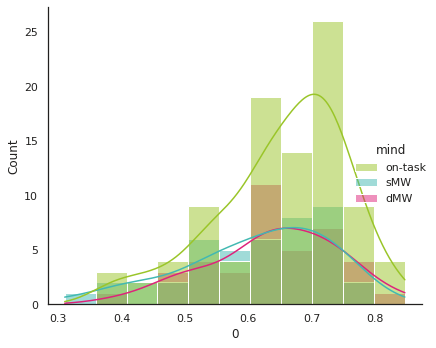

In [51]:
y_prob = pd.DataFrame(doc_forest.predict_proba(df_mind.drop('mind', axis =1 )))
y_prob['mind'] = df_mind.mind

sns.displot(data = y_prob, x = 0, hue = 'mind', kde = True)

## VS vs HC

In [66]:
classification = ['VS', 'HC']


agg_dict = {k: ["mean", 'std'] for k in markers}
agg_dict.update({k: "first" for k in df.drop(markers, axis=1).columns})

df_doc = (
    df.query(f"category in {classification}")
    .groupby(["participant", 'category'], as_index=False)
    .agg(agg_dict)
)

df_doc.columns = df_doc.columns.map("_".join)

df_doc = df_doc.rename(
    columns={
        "participant_first": "participant",
        "category_first": "category",
    }
).drop(["participant"], axis=1)


In [67]:
data = df_doc
label = 'category'
features = df_doc.drop('category', axis = 1).columns

cv_splits= 5
n_permutations = 1000
n_estimators = 1000
max_depth = None
max_features='auto'

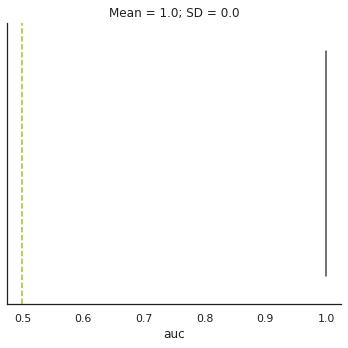

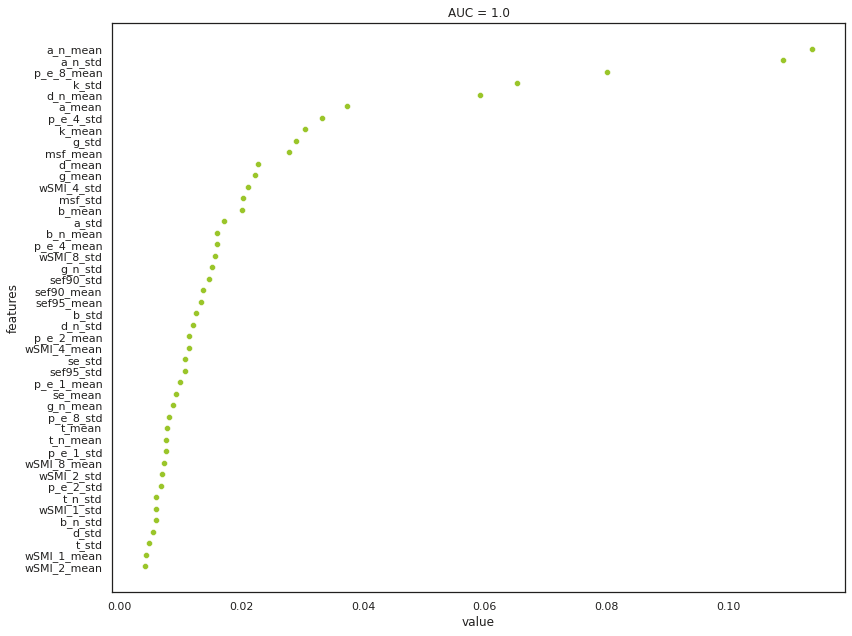

p_value = 0.000999000999000999


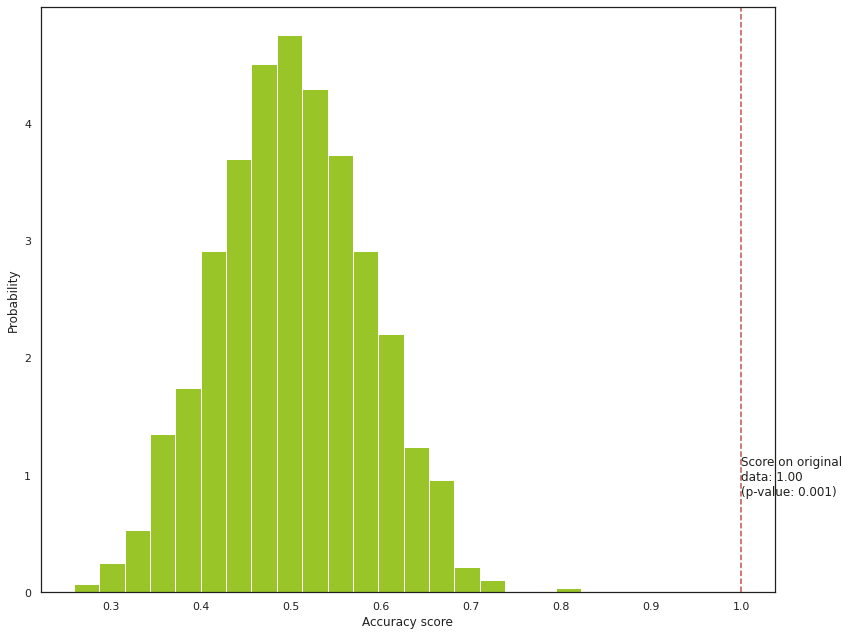

In [68]:
#pipeline steps init
steps = [("scaler", StandardScaler())]


y, lbl = pd.factorize(data[label])
X = data[features].astype("float32").values

steps.append(('Forest',ExtraTreesClassifier(
        n_estimators=n_estimators, max_features = max_features, criterion='entropy',
        max_depth=max_depth, random_state=42, class_weight=None)))

doc_forest = Pipeline(steps)

cv = KFold(cv_splits, shuffle=True, random_state = 42)


aucs = cross_val_score(
    X=X, y=y, estimator=doc_forest,
    scoring='roc_auc', cv=cv, groups=np.arange(len(X)), n_jobs = -1)


df_auc = pd.DataFrame(aucs, columns=["auc"])



sns.catplot(x = 'auc', orient = 'h', data = df_auc, kind = 'violin')
plt.title(f'Mean = {np.mean(df_auc.auc)}; SD = {np.std(df_auc.auc)}')
plt.axvline(x = 0.5, linestyle = 'dashed')
plt.show()


# Feature importance

doc_forest.fit(X, y)
variable_importance = doc_forest.steps[-1][-1].feature_importances_
sorter = variable_importance.argsort()

feat_import = pd.DataFrame(np.array([features,variable_importance]).T, 
                           columns = ['features', 'value']).sort_values('value', ascending = False)

sns.scatterplot(x = feat_import.value, y =feat_import.features)
plt.title(f'AUC = {np.mean(df_auc.auc)}')
plt.show()

score, perm_scores, pvalue = permutation_test_score(
    doc_forest, X, y, scoring="roc_auc", cv=cv, n_permutations=n_permutations, random_state = 42, n_jobs= -1
)


print(f"p_value = {pvalue}")

plt.hist(perm_scores, bins=20, density=True)
plt.axvline(score, ls="--", color="r")
score_label = (
    f"Score on original\ndata: {score:.2f}\n" f"(p-value: {pvalue:.3f})"
)
plt.text(score, np.max(perm_scores), score_label, fontsize=12)
plt.xlabel("Accuracy score")
plt.ylabel("Probability")
plt.show()


In [69]:
y_predicted_vs_hc  = doc_forest.predict(df_mind.drop('mind', axis =1 ))
print(lbl)
pd.crosstab(y_predicted_vs_hc, df_mind.mind).apply(lambda r: r/r.sum(), axis=0)

Index(['VS', 'HC'], dtype='object')


mind,dMW,on-task,sMW
row_0,,,
0,0.128205,0.159574,0.093023
1,0.871795,0.840426,0.906977


## MCS vs HC

In [70]:
classification = ['MCS', 'HC']

# df = df.drop(erps, axis = 1)

agg_dict = {k: ["mean", 'std'] for k in markers}
agg_dict.update({k: "first" for k in df.drop(markers, axis=1).columns})

df_doc = (
    df.query(f"category in {classification}")
    .groupby(["participant", 'category'], as_index=False)
    .agg(agg_dict)
)

df_doc.columns = df_doc.columns.map("_".join)

df_doc = df_doc.rename(
    columns={
        "participant_first": "participant",
        "category_first": "category",
    }
).drop(["participant"], axis=1)


In [71]:
data = df_doc
label = 'category'
features = df_doc.drop('category', axis = 1).columns

cv_splits= 5
n_permutations = 1000
n_estimators = 1000
max_depth = None
max_features='auto'

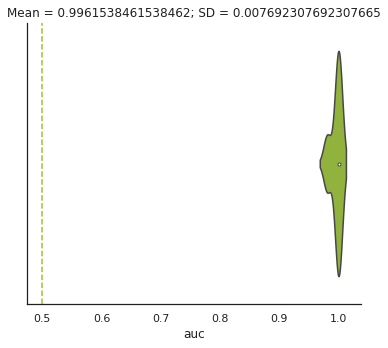

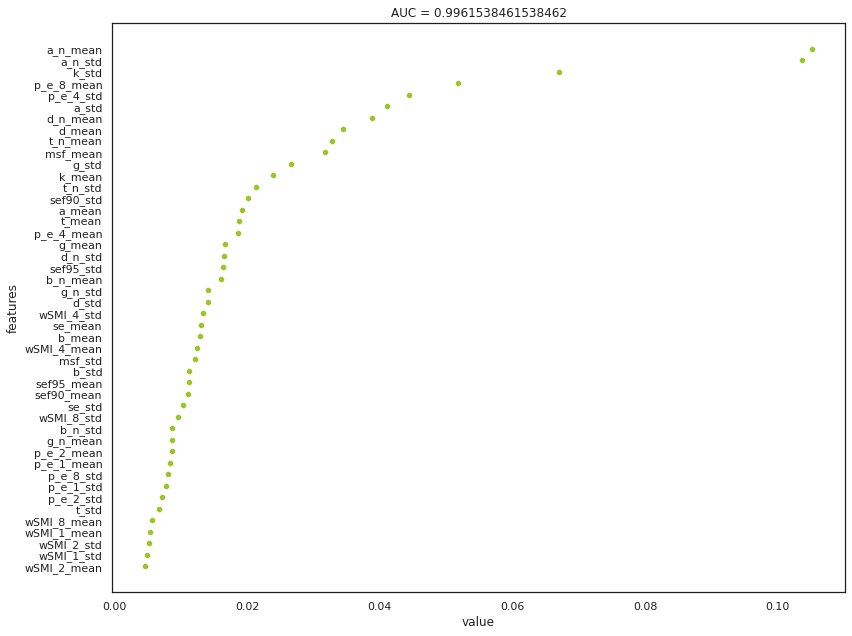

In [72]:
#pipeline steps init
steps = [("scaler", StandardScaler())]


y, lbl = pd.factorize(data[label])
X = data[features].astype("float32").values

steps.append(('Forest',ExtraTreesClassifier(
        n_estimators=n_estimators, max_features = max_features, criterion='entropy',
        max_depth=max_depth, random_state=42, class_weight=None)))

doc_forest = Pipeline(steps)

cv = KFold(cv_splits, shuffle=True, random_state = 42)


aucs = cross_val_score(
    X=X, y=y, estimator=doc_forest,
    scoring='roc_auc', cv=cv, groups=np.arange(len(X)), n_jobs = -1)


df_auc = pd.DataFrame(aucs, columns=["auc"])



sns.catplot(x = 'auc', orient = 'h', data = df_auc, kind = 'violin')
plt.title(f'Mean = {np.mean(df_auc.auc)}; SD = {np.std(df_auc.auc)}')
plt.axvline(x = 0.5, linestyle = 'dashed')
plt.show()


# Feature importance

doc_forest.fit(X, y)
variable_importance = doc_forest.steps[-1][-1].feature_importances_
sorter = variable_importance.argsort()

feat_import = pd.DataFrame(np.array([features,variable_importance]).T, 
                           columns = ['features', 'value']).sort_values('value', ascending = False)

sns.scatterplot(x = feat_import.value, y =feat_import.features)
plt.title(f'AUC = {np.mean(df_auc.auc)}')
plt.show()

# score, perm_scores, pvalue = permutation_test_score(
#     doc_forest, X, y, scoring="roc_auc", cv=cv, n_permutations=n_permutations, random_state = 42, n_jobs= -1
# )


# print(f"p_value = {pvalue}")

# plt.hist(perm_scores, bins=20, density=True)
# plt.axvline(score, ls="--", color="r")
# score_label = (
#     f"Score on original\ndata: {score:.2f}\n" f"(p-value: {pvalue:.3f})"
# )
# plt.text(score, np.max(perm_scores), score_label, fontsize=12)
# plt.xlabel("Accuracy score")
# plt.ylabel("Probability")
# plt.show()


In [73]:
y_predicted_mcs_hc  = doc_forest.predict(df_mind.drop('mind', axis =1 ))
print(lbl)
pd.crosstab(y_predicted_mcs_hc, df_mind.mind).apply(lambda r: r/r.sum(), axis=0)

Index(['MCS', 'HC'], dtype='object')


mind,dMW,on-task,sMW
row_0,,,
0,0.307692,0.425532,0.116279
1,0.692308,0.574468,0.883721


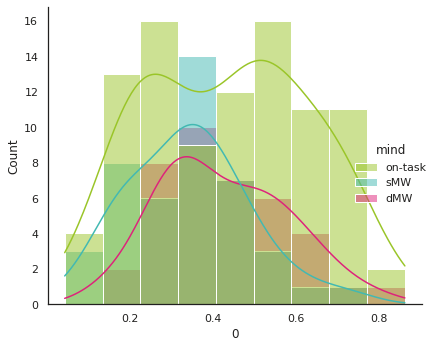

In [74]:
y_prob = pd.DataFrame(doc_forest.predict_proba(df_mind.drop('mind', axis =1 )))
y_prob['mind'] = df_mind.mind

sns.displot(data = y_prob, x = 0, hue = 'mind', kde = True)